In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
import pickle
#import matrix_factorization_utilities
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [2]:
#read in the ratings data
ratings = pd.read_csv("C:/Users/valen/OneDrive/Documents/ratings_small.csv")

In [3]:
len(ratings)

100004

In [4]:
#only takig three columns userId, movieID and rating into the df
ratings = ratings[['userId', 'movieId','rating']]

In [5]:
#need to check if the user has multiple ratings for a movie because if so we can just condense them to be the max
#using np.max
ratings

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [6]:
#need to check if the user has multiple ratings for a movie because if so we can just condense them to be the max
#using np.max
ratings_df = ratings.groupby(['userId','movieId']).aggregate(np.max)

In [7]:
#lets print out the length to see if there were any changes, ofcourse it will be left after aggregating
len(ratings_df)

100004

In [8]:
#we see that the length is the same as before, so no user has made a review more than once on a movie
#lets move on in inspecting the ratings data a bit further

In [9]:
#first five
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [10]:
ratings_df.head()

rating
userId movieId        
1      31          2.5
       1029        3.0
       1061        3.0
       1129        2.0
       1172        4.0

In [11]:
#see how many unique ids there are 
len(ratings['userId'].unique())

671

In [12]:
#get the percentage of each rating value
#first get the number of each rating and then divide by the total
count_ratings = ratings.groupby('rating').count()
#create a new column per_total 
count_ratings['per_total']=round(count_ratings['userId']*100/count_ratings['userId'].sum(),1)

In [13]:
count_ratings

,userId,movieId,per_total
rating,,,
0.5,1101,1101,1.1
1.0,3326,3326,3.3
1.5,1687,1687,1.7
2.0,7271,7271,7.3
2.5,4449,4449,4.4
3.0,20064,20064,20.1
3.5,10538,10538,10.5
4.0,28750,28750,28.7
4.5,7723,7723,7.7


<AxesSubplot:xlabel='rating'>

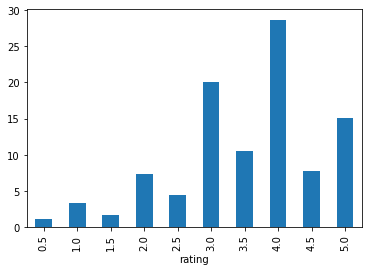

In [14]:
#use ply plot.bar the to visualize the per total using a bar graph
count_ratings['per_total'].plot.bar()

In [15]:
#now lets read in the movies dataset
movie_list = pd.read_csv("C:/Users/valen/OneDrive/Documents/movies.csv")

In [16]:
len(movie_list)

9742

In [17]:
#lets see the file
movie_list.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
#no lets read the tags intnto tags df 
tags = pd.read_csv("C:/Users/valen/OneDrive/Documents/tags.csv")

In [19]:
#lets see the file
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [20]:
#create a genres_df of the column genres from the movie_list df
genres = movie_list['genres']

In [21]:
genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

In [22]:
#cleaning
#we see that the genres are formatted using | to sepearate the generes so we will split the genres from them and create
#a new list based on the split genres into new_list and then remove the blank 

In [23]:
genre_list = ""
for index,row in movie_list.iterrows():
        genre_list += row.genres + "|"
#split the string into a list of values
genre_list_split = genre_list.split('|')
#de-duplicate values
new_list = list(set(genre_list_split))
#remove the value that is blank
new_list.remove('')
#let's see it now
new_list

['Romance',
 'Crime',
 'Thriller',
 'Horror',
 'Fantasy',
 'War',
 'Western',
 'IMAX',
 'Musical',
 'Animation',
 'Action',
 'Comedy',
 'Sci-Fi',
 'Children',
 '(no genres listed)',
 'Documentary',
 'Film-Noir',
 'Adventure',
 'Drama',
 'Mystery']

In [24]:
#lets add the generes into their own columns using .copy on the movie_list
movies_with_genres = movie_list.copy()

In [25]:
for genre in new_list :
    movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)

movies_with_genres.head() #df with new columns with generes

,movieId,title,genres,Romance,Crime,Thriller,Horror,Fantasy,War,Western,...,Action,Comedy,Sci-Fi,Children,(no genres listed),Documentary,Film-Noir,Adventure,Drama,Mystery
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [26]:
#lets check the sparisty by taking the length of the ratings divided by the unique no of users and number of movies
num_users = len(ratings['userId'].unique())
num_movies = len(ratings['movieId'].unique())

In [27]:
sparsity = round(1.0 - len(ratings)/(1.0*(num_movies*num_users)),3)
print(sparsity)

0.984


In [28]:
#count the number of unique elements in movieID
len(ratings['movieId'].unique())

9066

In [29]:
#now we will find the average rating for a movie and then the number of ratings for each movie 
#so can use aggregate function .agg for the average/mean of a rating and the count
avg_movie_rating = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['mean','count']))

In [30]:
# avg_movie_rating['movieId']= avg_movie_rating.index

In [31]:
#lets see
avg_movie_rating.head()

,mean,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [32]:
len(avg_movie_rating)

9066

In [38]:
#calculate the percentile count
np.percentile(avg_movie_rating['count'],60)

4.0

In [39]:
#the average movie rating for all movies 
avg_rating_all=ratings['rating'].mean()
avg_rating_all

3.543608255669773

In [40]:
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30 #30 is reasonable
min_reviews

30

In [41]:
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
5,3.267857,56
6,3.884615,104


In [42]:
len(movie_score)

821